<a href="https://colab.research.google.com/github/sh01k/teaching/blob/master/wiener_filter.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**準備**

クリーンな音声ファイル（wave形式）をダウンロードします。このファイルは以下のデータベースから取得したものです。

http://www.festvox.org/cmu_arctic/

In [0]:
!wget -O test.wav "https://drive.google.com/uc?export=download&id=15VyUDMAXYF_7crH7TfjMysG35S4OuKDt"
filename = "./test.wav"

--2020-04-29 06:57:07--  https://drive.google.com/uc?export=download&id=15VyUDMAXYF_7crH7TfjMysG35S4OuKDt
Resolving drive.google.com (drive.google.com)... 108.177.126.113, 108.177.126.100, 108.177.126.101, ...
Connecting to drive.google.com (drive.google.com)|108.177.126.113|:443... connected.
HTTP request sent, awaiting response... 302 Moved Temporarily
Location: https://doc-0k-6o-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/3d4hrvvob2tdvhb73reso0p6k7u4na4n/1588143375000/12513266162329107218/*/15VyUDMAXYF_7crH7TfjMysG35S4OuKDt?e=download [following]
--2020-04-29 06:57:07--  https://doc-0k-6o-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/3d4hrvvob2tdvhb73reso0p6k7u4na4n/1588143375000/12513266162329107218/*/15VyUDMAXYF_7crH7TfjMysG35S4OuKDt?e=download
Resolving doc-0k-6o-docs.googleusercontent.com (doc-0k-6o-docs.googleusercontent.com)... 172.217.218.132, 2a00:1450:4013:c08::84
Connecting to doc-0k-6o-docs.googleusercontent.com (d

**ファイル読み込み**

次に音声ファイルを読み込み，波形のプロットと音声の再生を行います。

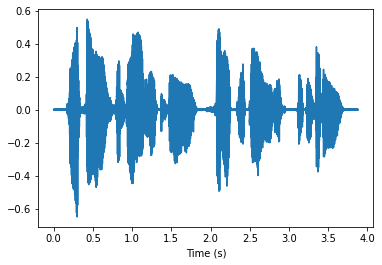

In [0]:
import numpy as np
from matplotlib import pyplot as plt
import wave
import IPython.display

# Open audio file
wf = wave.open(filename, mode='rb')

# Sampling frequency
fs = int(wf.getframerate())

# Samples
nsamples = wf.getnframes()
t = np.arange(nsamples)/fs

#FFT parameters
fftlen = 512
fftshift = fftlen/2

# Frequency
f = np.arange(fftlen/2)*fs/fftlen

# Window function
win = np.sqrt(np.hanning(fftlen))

# Read to buffer
buf = wf.readframes(-1)
if wf.getsampwidth() == 2:
  data = np.frombuffer(buf, dtype='int16')/(2**(16-1))
elif wf.getsampwidth() == 4:
  data = np.frombuffer(buf, dtype='int32')/(2**(32-1))

nchannels = wf.getnchannels()
if nchannels>1:
  s = data[:: nchannels]
else:
  s = data

# Close audio file
wf.close()

# Plot clean speech
plt.plot(t,s)
plt.xlabel("Time (s)")
plt.show()

IPython.display.Audio(s, rate=fs)

**観測信号の生成**

SN比10dBで白色雑音を加えることで，観測信号を生成します。これも波形のプロットと音声の再生を行います。

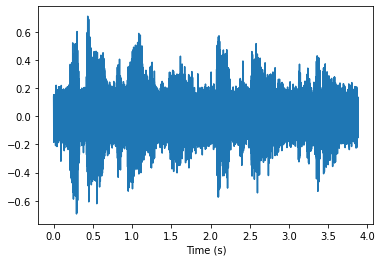

In [0]:
snr = 10
Ps_i = sum(abs(s))/len(s)
Pn_i = Ps_i/(10**(snr/10))

# Generate noise
n = np.random.normal(0,np.sqrt(Pn_i),nsamples)

# Observation
x = s + n

# Plot observation
plt.plot(t,x)
plt.xlabel("Time (s)")
plt.show()

IPython.display.Audio(x, rate=fs)

**雑音のパワースペクトル密度推定**

観測信号の中で音声が含まれていないと思われる，最初の10フレーム分を使って，雑音のパワースペクトル密度を推定します。周波数ごとの推定された雑音のパワースペクトル密度をプロットします。

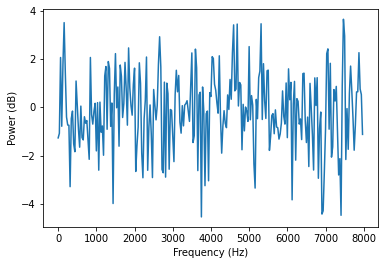

In [0]:
# Estimate noise amplitude from first several frames
nFrame_noise = 10
Sn = np.zeros(fftlen)
for tt in range(nFrame_noise):
  x_t = x[int(tt*fftshift):int(tt*fftshift+fftlen)]*win
  Sn = Sn + abs(np.fft.fft(x_t,fftlen))
Sn = Sn/nFrame_noise

# Plot noise freq vs PSD
plt.plot(f,20*np.log10(Sn[0:int(fftlen/2)]))
plt.xlabel("Frequency (Hz)")
plt.ylabel("Power (dB)")
plt.show()

**ウィナーフィルタによる雑音除去**

ウィナーフィルタによる雑音除去を行います。これをスペクトル減算法と呼びます。雑音除去された音声波形のプロットと再生を行います。

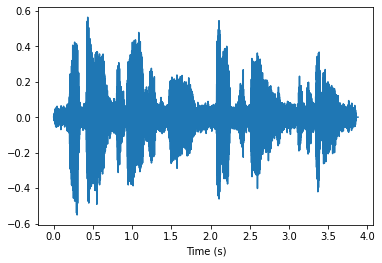

In [0]:
# Filtering
s_est = np.zeros(nsamples)

for tt in range(int(np.floor((nsamples-fftlen)/fftshift))):
  x_t = x[int(tt*fftshift):int(tt*fftshift+fftlen)]*win
  xf_t = np.fft.fft(x_t,fftlen)
  Sx = abs(xf_t)

  # Spectral subtraction to estimate speech psd
  Ss = np.maximum(Sx-Sn, 0)

  Pn = Sn**2
  Ps = Ss**2
  WF = Ps/(Pn+Ps)

  sf_t = xf_t * WF
  s_t = np.real(np.fft.ifft(sf_t,fftlen))*win
  s_est[int(tt*fftshift):int(tt*fftshift+fftlen)] = s_est[int(tt*fftshift):int(tt*fftshift+fftlen)] + s_t

#Plot estimated speech
plt.plot(t,s_est)
plt.xlabel("Time (s)")
plt.show()

IPython.display.Audio(s_est, rate=fs)